# Persian Handwritten Digit Recognition With Scikit-Learn

Author: **Marcin Sikorski**<br>
Date: October, 2024

Update of classification task on Persian handwritten digits. The predictions will be performed with `scikit-learn` models.

**Notebook Content:**
1. Setting Environment and Reading Dataset
2. Generating Training and Testing Data<br>
   2.1. Train Data<br>
   2.2. Test Data<br>
3. Preprocessing and Splitting Data
4. Hard Voting vs. Soft Voting<br>
   4.1. Classification Report<br>
   4.2. Confusion Matrix<br>
   4.3. Cross-Validation Evaluation<br>
   4.4. ROC Curves<br>
5. Conclusion

### 1. Setting Environment and Reading Dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
train_dir = 'persian-handwritten-digits/Train/'
test_dir = 'persian-handwritten-digits/Test/'

filelist = os.listdir(train_dir)

print('Image distribution in train dataset:')
for i in filelist:
    print(f'{i}: {len(os.listdir(train_dir + str(i)))} images')
    
filelist = os.listdir(test_dir)

print('\nImage distribution in test dataset:')
for i in filelist:
    print(f'{i}: {len(os.listdir(test_dir + str(i)))} images')

Image distribution in train dataset:
class_0: 10000 images
class_1: 10000 images
class_2: 10000 images
class_3: 10000 images
class_4: 10000 images
class_5: 10000 images
class_6: 10000 images
class_7: 10000 images
class_8: 10000 images
class_9: 10000 images

Image distribution in test dataset:
class_0: 5000 images
class_1: 5000 images
class_2: 5000 images
class_3: 5000 images
class_4: 5000 images
class_5: 5000 images
class_6: 5000 images
class_7: 5000 images
class_8: 5000 images
class_9: 5000 images


### 2. Generating Training and Testing Data

To prepare our data for further machine learning we will implement the following steps for each subset:
* retrieve and list paths to all images,
* convert images into separate NumPy arrays and stack them into one array,
* generate image labels and stack them into one long vector (one-dimensional array).

In [3]:
def get_paths(dataset):
    if dataset == 'train':
        filelist = os.listdir(train_dir)
        
        # lists paths in 'train_dir'
        paths = []
        for x in filelist:
            if x.startswith('class_'):
                paths.append(train_dir + x + '/')
                
        all_images = []
        
        # lists JPG files in all directories
        for i in paths:
            filelist_2 = os.listdir(i)
            for j in filelist_2:
                if j.endswith('.jpg'):
                    all_images.append(i + j)
                    
    if dataset == 'test':
        filelist = os.listdir(test_dir)
        
        # lists paths in 'test_dir'
        path = []
        for x in filelist:
            if x.startswith('class_'):
                path.append(test_dir + x + '/')
                
        all_images = []
        
        # lists JPG files in all directories
        for i in path:
            filelist_2 = os.listdir(i)
            for j in filelist_2:
                if j.endswith('.jpg'):
                    all_images.append(i + j)
                    
    return all_images
                    
train_paths = get_paths(dataset='train')
test_paths = get_paths(dataset='test')

**2.1. Train Data**

In [4]:
train_data = []
img_shape = 28 * 28

for file in train_paths:
    img = Image.open(file)
    array_temp = np.array(img)
    
    # convert to grayscale if image is in RGB
    if array_temp.ndim == 3:
        # average across the RGB channel
        array_temp = np.mean(array_temp, axis=2)

    # flatten image & append to listt
    img_wide = array_temp.flatten()
    train_data.append(img_wide)

In [5]:
labels = []

for i in range(10):
    labels.append([i] * 10_000)
        
train_labels = []
for row in labels:
    train_labels.extend(row)

print('Training images:', len(train_data))
print('Training labels:', len(train_labels))

Training images: 100000
Training labels: 100000


**2.2. Test Data**

In [6]:
test_data = []
img_shape = 28 * 28

for file in test_paths:
    img = Image.open(file)
    array_temp = np.array(img)
    
    # convert to grayscale if image is in RGB
    if array_temp.ndim == 3:
        # average across the RGB channel
        array_temp = np.mean(array_temp, axis=2)

    # flatten image & append to listt
    img_wide = array_temp.flatten()
    test_data.append(img_wide)

In [7]:
labels = []

for i in range(10):
    labels.append([i] * 5_000)
        
test_labels = []
for row in labels:
    test_labels.extend(row)

print('Testing images:', len(test_data))
print('Testing labels:', len(test_labels))

Testing images: 50000
Testing labels: 50000


### 3. Preprocessing and Splitting Data

We will normalize the data so that array values will be set in range [0, 1]. In this step we will also partion our dataset into training and validation sets with a 80:20 ratio and apply shuffling.

In [8]:
from sklearn.preprocessing import normalize

# merge all images & labels
data = train_data + test_data
labels = train_labels + test_labels

# normalize image vector into [0., 1.] range
norm_data = normalize(data, norm='max')

print('Number of images:', norm_data.shape[0])
print('Image shape:', norm_data[0].shape)

Number of images: 150000
Image shape: (784,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_data, labels, train_size=0.8, shuffle=True, random_state=42)

print('Training samples:', len(X_train))
print('Testing samples:', len(X_test))

Training samples: 120000
Testing samples: 30000


### 4. Hard Voting vs. Soft Voting

**Hard voting** (also known as majority voting), the models predict the output class independent of each other. The output class is a class with the highest majority of votes.

Example: five classifiers predict the output class $(A, A, B, A, B)$. The majority predicted $A$ as an output. Therefore $A$ will be the final prediction.

In **soft voting**, the output class is the prediction based on the average of probability given to that class. Soft voting entails combining the probabilities of each prediction in each model and picking the prediction with the highest total probability.

Example: five classifiers predict the output class $A = (0.30, 0.47, 0.53, 0.71, 0.64)$ and $B = (0.20, 0.32, 0.40, 0.35, 0.25)$. The average for class $A$ is 0.5300 and $B$ is 0.3040, the winner is clearly class $A$ because it had the highest probability averaged by each classifier.

We will evaluate the classification performance with typical evaluation metrics and visualizations (heatmap, ROC curves).

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import sklearn.metrics as metrics

# initialize list of classifiers
estimator_models = []
estimator_models.append(('Grad Boosting', HistGradientBoostingClassifier()))
estimator_models.append(('K-Neighbors', KNeighborsClassifier()))
estimator_models.append(('LightGBM', LGBMClassifier(verbose=-1)))

voting_clf = VotingClassifier(estimators=estimator_models, voting='hard').fit(X_train, y_train)

# predictions
y_pred = voting_clf.predict(X_test)

# evaluation metrics
acc = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred, average='micro')
matthews = metrics.matthews_corrcoef(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred, average='micro')
prec = metrics.precision_score(y_test, y_pred, average='micro')

print(f'Accuracy: {acc:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Matthews: {matthews:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {prec:.4f}')

Accuracy: 0.9975
F1 score: 0.9975
Matthews: 0.9973
Recall: 0.9975
Precision: 0.9975


In [11]:
# display each performance
for i in (0, 1, 2):
    name = estimator_models[i][0]
    pred = voting_clf.named_estimators_[name].predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    print(f'{name} accuracy score: {score:.6f}')

Grad Boosting accuracy score: 0.997500
K-Neighbors accuracy score: 0.994167
LightGBM accuracy score: 0.997400


**4.1. Classification Report**

In [12]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3010
           1       1.00      1.00      1.00      2934
           2       0.99      0.99      0.99      3018
           3       1.00      0.99      0.99      3030
           4       1.00      1.00      1.00      2974
           5       1.00      1.00      1.00      2949
           6       1.00      1.00      1.00      3003
           7       1.00      1.00      1.00      2996
           8       1.00      1.00      1.00      2985
           9       1.00      1.00      1.00      3101

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



**4.2. Confusion Matrix**

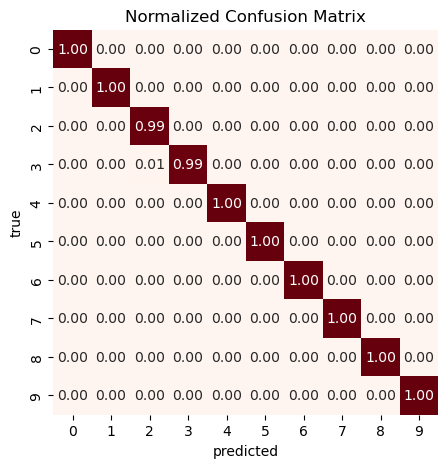

In [13]:
from seaborn import heatmap

plt.figure(figsize=(5, 5))
cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
heatmap(cm, annot=True, cmap='Reds', fmt='.2f', square=True, cbar=False)
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('Normalized Confusion Matrix')
plt.show()

**4.3. Cross-Validation Evalaution**

In [14]:
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev

cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
voting_cv_mean = mean(cv_scores)
voting_cv_stdev = stdev(cv_scores)

print(f'Cross-validation accuracy scores:\n{cv_scores}')
print(f'\nAverage cross-validation accuracy score: {voting_cv_mean:.4f} ± {voting_cv_stdev:.4f}')

Cross-validation accuracy scores:
[0.997125   0.99725    0.99691667 0.99708333 0.997625  ]

Average cross-validation accuracy score: 0.9972 ± 0.0003


**4.4. ROC Curves**

Since the histogram-based gradient boosting classification model had the highest accuracy score, we will apply it for new predictions and display the ROC curves for each Persian digit (class).

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

# binarize the target feature
y_bin = label_binarize(labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_bin.shape[1]

# split new data
X_train, X_test, y_train, y_test = train_test_split(norm_data, y_bin, train_size=0.8, random_state=42)

# initialize and fit classifier
clf = OneVsRestClassifier(HistGradientBoostingClassifier())
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)

# compute TPR and FPR for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# optional: display ROC-AUC scores
output = '\n'.join(f'ROC-AUC for {key}: {roc_auc[key]:.4f}' for key in roc_auc)
print(output)

ROC-AUC for 0: 1.0000
ROC-AUC for 1: 0.9999
ROC-AUC for 2: 0.9999
ROC-AUC for 3: 0.9999
ROC-AUC for 4: 1.0000
ROC-AUC for 5: 1.0000
ROC-AUC for 6: 1.0000
ROC-AUC for 7: 1.0000
ROC-AUC for 8: 1.0000
ROC-AUC for 9: 1.0000
ROC-AUC for micro: 1.0000
ROC-AUC for macro: 1.0000


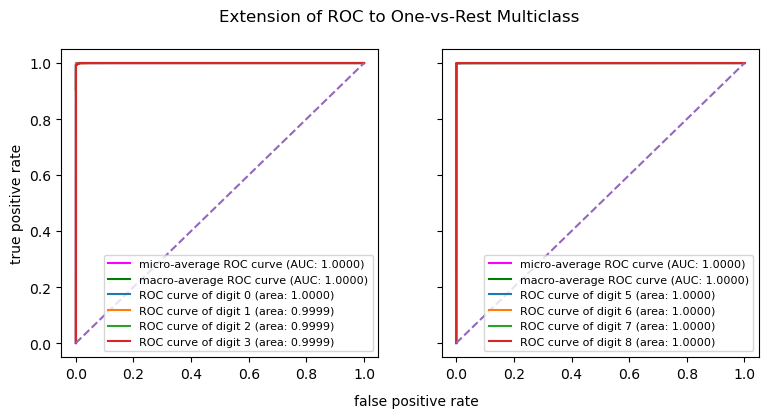

In [16]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
fig.suptitle('Extension of ROC to One-vs-Rest Multiclass')
fig.text(0.45, 0.0001, s='false positive rate', va='center')

# 1. plot ROC curves for: 0, 1, 2, 3, 4
axs[0].plot(fpr['micro'], tpr['micro'], label=f'micro-average ROC curve (AUC: {roc_auc['micro']:.4f})',
         color='magenta')
axs[0].plot(fpr['macro'], tpr['macro'], label=f'macro-average ROC curve (AUC: {roc_auc['macro']:.4f})',
         color='green')

for i in range(0, 4):
    axs[0].plot(fpr[i], tpr[i], label=f'ROC curve of digit {i} (area: {roc_auc[i]:.4f})')
    
axs[0].plot([0, 1], [0, 1], linestyle='--')
axs[0].legend(loc='lower right', prop={'size': 8})
axs[0].set(ylabel='true positive rate',
           xlim=[-0.05, 1.05],
           ylim=[-0.05, 1.05],
          )

# 2. plot ROC curves for: 5, 6, 7, 8, 9
axs[1].plot(fpr['micro'], tpr['micro'], label=f'micro-average ROC curve (AUC: {roc_auc['micro']:.4f})',
         color='magenta')
axs[1].plot(fpr['macro'], tpr['macro'], label=f'macro-average ROC curve (AUC: {roc_auc['macro']:.4f})',
         color='green')

for i in range(5, 9):
    axs[1].plot(fpr[i], tpr[i], label=f'ROC curve of digit {i} (area: {roc_auc[i]:.4f})')
    
axs[1].plot([0, 1], [0, 1], linestyle='--')
axs[1].legend(loc='lower right', prop={'size': 8})
axs[1].set(#ylabel='true positive rate',
           xlim=[-0.05, 1.05],
           ylim=[-0.05, 1.05],
          )

plt.show()

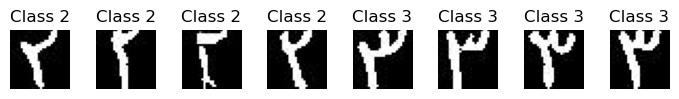

In [17]:
from random import sample

# filter paths for 'class_2' and 'class_3'
class_2_paths = [path for path in train_paths if 'class_2' in path]
class_3_paths = [path for path in train_paths if 'class_3' in path]

# select random images from each class
random_images_2 = sample(class_2_paths, 4)
random_images_3 = sample(class_3_paths, 4)

plt.figure(figsize=(7, 1))

# plot class 2
for i, img_path in enumerate(random_images_2):
    img = Image.open(img_path)
    plt.subplot(1, 8, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Class 2')

# plot class 3
for i, img_path in enumerate(random_images_3):
    img = Image.open(img_path)
    plt.subplot(1, 8, i + 5)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Class 3')

plt.tight_layout()
plt.show()

### 5. Conclusion

The task of this notebook was to perform a classification problem (image recognition) on Persian handwritten digits. We applied commonly used `scikit-learn` estimators and hard voting rule (majority vote) to decide final predictions.

The performance scores achieved on the test dataset show high efficiency. The best model in the hard voting rule was the histogram-based gradient boosting estimator with 0.9972 accuracy in cross-validation - this evaluation technique is more robust. No hyperparameter tuning was necessary. The classification report, confusion matrix, and ROC-AUC scores prove Persian twos and threes to be the hardest to predict. Indeed, they look very similar. Remaining digits were almost perfectly predicted.